### Notebook for the label transfer of Healthy Skin to study Skin using `scANVI`

- **Developed by:** Carlos Talavera-López Ph.D
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- v2300704

### Import required modules

In [1]:
import scvi
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

Global seed set to 0


### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.4.0
absl                NA
appnope             0.1.3
asttokens           NA
attr                22.2.0
backcall            0.2.0
brotli              NA
certifi             2022.12.07
cffi                1.15.1
charset_normalizer  2.1.1
chex                0.1.5
colorama            0.4.6
comm                0.1.2
contextlib2         NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.6
decorator           5.1.1
docrep              0.3.2
executing           1.2.0
flax                0.5.0
fsspec              2023.1.0
gmpy2               2.1.2
h5py                3.8.0
idna                3.4
igraph              0.10.4
ipykernel           6.21.1
ipywidgets          8.0.4
jax                 0.4.2
jaxlib              0.4.2
jedi                0.18.2
joblib              1.2.0
kiwisolver          1.4.4
leidenalg           0.9.1
lightning_fabric    1.9.0
lightning_utilities

In [3]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

Global seed set to 1712


In [4]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

### Read in Healthy data

In [5]:
healthy_raw = sc.read_h5ad('../data/skin_healthy_adult_processed.h5ad')
healthy_raw

AnnData object with n_obs × n_vars = 195739 × 28728
    obs: 'sample_id', 'Status', 'Site', 'Tissue', 'Location', 'donor_id', 'Sex', 'full_clustering', 'seed_labels', 'donor', 'cell_states'
    var: 'gene_ids-SKN8090524', 'feature_types-SKN8090524', 'gene_ids-SKN8090525', 'feature_types-SKN8090525', 'gene_ids-SKN8090526', 'feature_types-SKN8090526', 'gene_ids-SKN8090527', 'feature_types-SKN8090527', 'gene_ids-SKN8090528', 'feature_types-SKN8090528', 'gene_ids-SKN8090529', 'feature_types-SKN8090529', 'gene_ids-SKN8090530', 'feature_types-SKN8090530', 'gene_ids-SKN8090531', 'feature_types-SKN8090531', 'gene_ids-SKN8090536', 'feature_types-SKN8090536', 'gene_ids-SKN8090537', 'feature_types-SKN8090537', 'gene_ids-SKN8090538', 'feature_types-SKN8090538', 'gene_ids-SKN8090539', 'feature_types-SKN8090539', 'gene_ids-SKN8090540', 'feature_types-SKN8090540', 'gene_ids-SKN8090541', 'feature_types-SKN8090541', 'gene_ids-SKN8090542', 'feature_types-SKN8090542', 'gene_ids-SKN8090543', 'feature_type

- Remove annotations with less than 10 cells

In [6]:
healthy_raw.obs['seed_labels'].value_counts()

Differentiated_KC      32496
Undifferentiated_KC    21348
Th                     20617
VE2                    15511
moDC                   12490
migLC                  11977
F1                     10161
VE1                     9645
Tc                      8680
Macro_1                 5781
Treg                    5743
Mono_mac                4912
Pericyte_1              4705
F2                      4260
LE2                     3851
Melanocyte              3682
F3                      3035
ILC1_3                  2935
ILC1_NK                 2604
MigDC                   2080
Inf_mac                 1773
Macro_2                 1424
LE1                     1073
NK                       739
DC2                      724
VE3                      629
DC1                      604
LC                       568
Mast_cell                557
ILC2                     494
Pericyte_2               301
Schwann_1                149
Schwann_2                120
Plasma                    71
Name: seed_lab

In [7]:
healthy_raw.obs['seed_labels'].value_counts()

Differentiated_KC      32496
Undifferentiated_KC    21348
Th                     20617
VE2                    15511
moDC                   12490
migLC                  11977
F1                     10161
VE1                     9645
Tc                      8680
Macro_1                 5781
Treg                    5743
Mono_mac                4912
Pericyte_1              4705
F2                      4260
LE2                     3851
Melanocyte              3682
F3                      3035
ILC1_3                  2935
ILC1_NK                 2604
MigDC                   2080
Inf_mac                 1773
Macro_2                 1424
LE1                     1073
NK                       739
DC2                      724
VE3                      629
DC1                      604
LC                       568
Mast_cell                557
ILC2                     494
Pericyte_2               301
Schwann_1                149
Schwann_2                120
Plasma                    71
Name: seed_lab

### Read in other unannotated datasets

In [8]:
SCC0120_1 = sc.read_h5ad('../data/SCC0120_1_QCed_pre-processed_ctl230701.h5ad')
SCC0120_1.obs['tissue'].cat.categories

Index(['pbmc', 'skin'], dtype='object')

In [9]:
SCC0120_1

AnnData object with n_obs × n_vars = 8839 × 36611
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_CITE', 'nFeature_CITE', 'nCount_PROT', 'nFeature_PROT', 'percent.mt', 'sample', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'tissue', 'condition', 'n_genes', 'doublet_scores', 'predicted_doublets', 'hashtag', 'unique', 'group', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'S_score', 'G2M_score'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'batch_colors', 'tissue_colors'
    layers: 'counts', 'sqrt_norm'

In [10]:
SCC0120_1_skin = SCC0120_1[SCC0120_1.obs['tissue'].isin(['skin'])]
SCC0120_1_skin.obs['seed_labels'] = 'Unknown'
SCC0120_1_skin.obs['donor'] = SCC0120_1_skin.obs['sample'].copy()
SCC0120_1_skin

AnnData object with n_obs × n_vars = 7479 × 36611
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_CITE', 'nFeature_CITE', 'nCount_PROT', 'nFeature_PROT', 'percent.mt', 'sample', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'tissue', 'condition', 'n_genes', 'doublet_scores', 'predicted_doublets', 'hashtag', 'unique', 'group', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'S_score', 'G2M_score', 'seed_labels', 'donor'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'batch_colors', 'tissue_colors'
    layers: 'counts', 'sqrt_norm'

In [11]:
adata = healthy_raw.concatenate(SCC0120_1_skin, batch_key = 'group', batch_categories = ['healthy_skin', 'SCC0120_1_skin'], join = 'inner')
adata

AnnData object with n_obs × n_vars = 203218 × 27449
    obs: 'sample_id', 'Status', 'Site', 'Tissue', 'Location', 'donor_id', 'Sex', 'full_clustering', 'seed_labels', 'donor', 'cell_states', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_CITE', 'nFeature_CITE', 'nCount_PROT', 'nFeature_PROT', 'percent.mt', 'sample', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'tissue', 'condition', 'n_genes', 'doublet_scores', 'predicted_doublets', 'hashtag', 'unique', 'group', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'S_score', 'G2M_score'
    var: 'gene_ids-SCC0120_1_skin', 'feature_types-SCC0120_1_skin', 'mt-SCC0120_1_skin', 'ribo-SCC0120_1_skin', 'n_cells_by_counts-SCC0120_1_skin', 'mean_counts-SCC0120_1_skin', 'pct_dropout_by_counts-SCC0120_1_skin', 'total_counts-SCC0120_1_skin', '

### Select HVGs

In [12]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "donor",
    subset = True
)

adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 203218 × 7000
    obs: 'sample_id', 'Status', 'Site', 'Tissue', 'Location', 'donor_id', 'Sex', 'full_clustering', 'seed_labels', 'donor', 'cell_states', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_CITE', 'nFeature_CITE', 'nCount_PROT', 'nFeature_PROT', 'percent.mt', 'sample', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'tissue', 'condition', 'n_genes', 'doublet_scores', 'predicted_doublets', 'hashtag', 'unique', 'group', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'S_score', 'G2M_score'
    var: 'gene_ids-SCC0120_1_skin', 'feature_types-SCC0120_1_skin', 'mt-SCC0120_1_skin', 'ribo-SCC0120_1_skin', 'n_cells_by_counts-SCC0120_1_skin', 'mean_counts-SCC0120_1_skin', 'pct_dropout_by_counts-SCC0120_1_skin', 'total_counts-SCC0120_1_skin', 'g

### Transfer of annotation with scANVI

In [13]:
scvi.model.SCVI.setup_anndata(adata, batch_key = 'donor', labels_key = "seed_labels")

In [14]:
scvi_model = scvi.model.SCVI(adata, n_latent = 50, n_layers = 3)

In [15]:
scvi_model.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 39/39: 100%|██████████| 39/39 [47:06<00:00, 72.94s/it, loss=1.54e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=39` reached.


Epoch 39/39: 100%|██████████| 39/39 [47:06<00:00, 72.47s/it, loss=1.54e+03, v_num=1]


### Label transfer with `scANVI` 

In [16]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [17]:
scanvi_model.train()

INFO     Training for 10 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 10/10: 100%|██████████| 10/10 [21:48<00:00, 135.31s/it, loss=1.64e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [21:48<00:00, 130.83s/it, loss=1.64e+03, v_num=1]


In [18]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [19]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

- Visualise corrected dataset

computing neighbors


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:49)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:43)


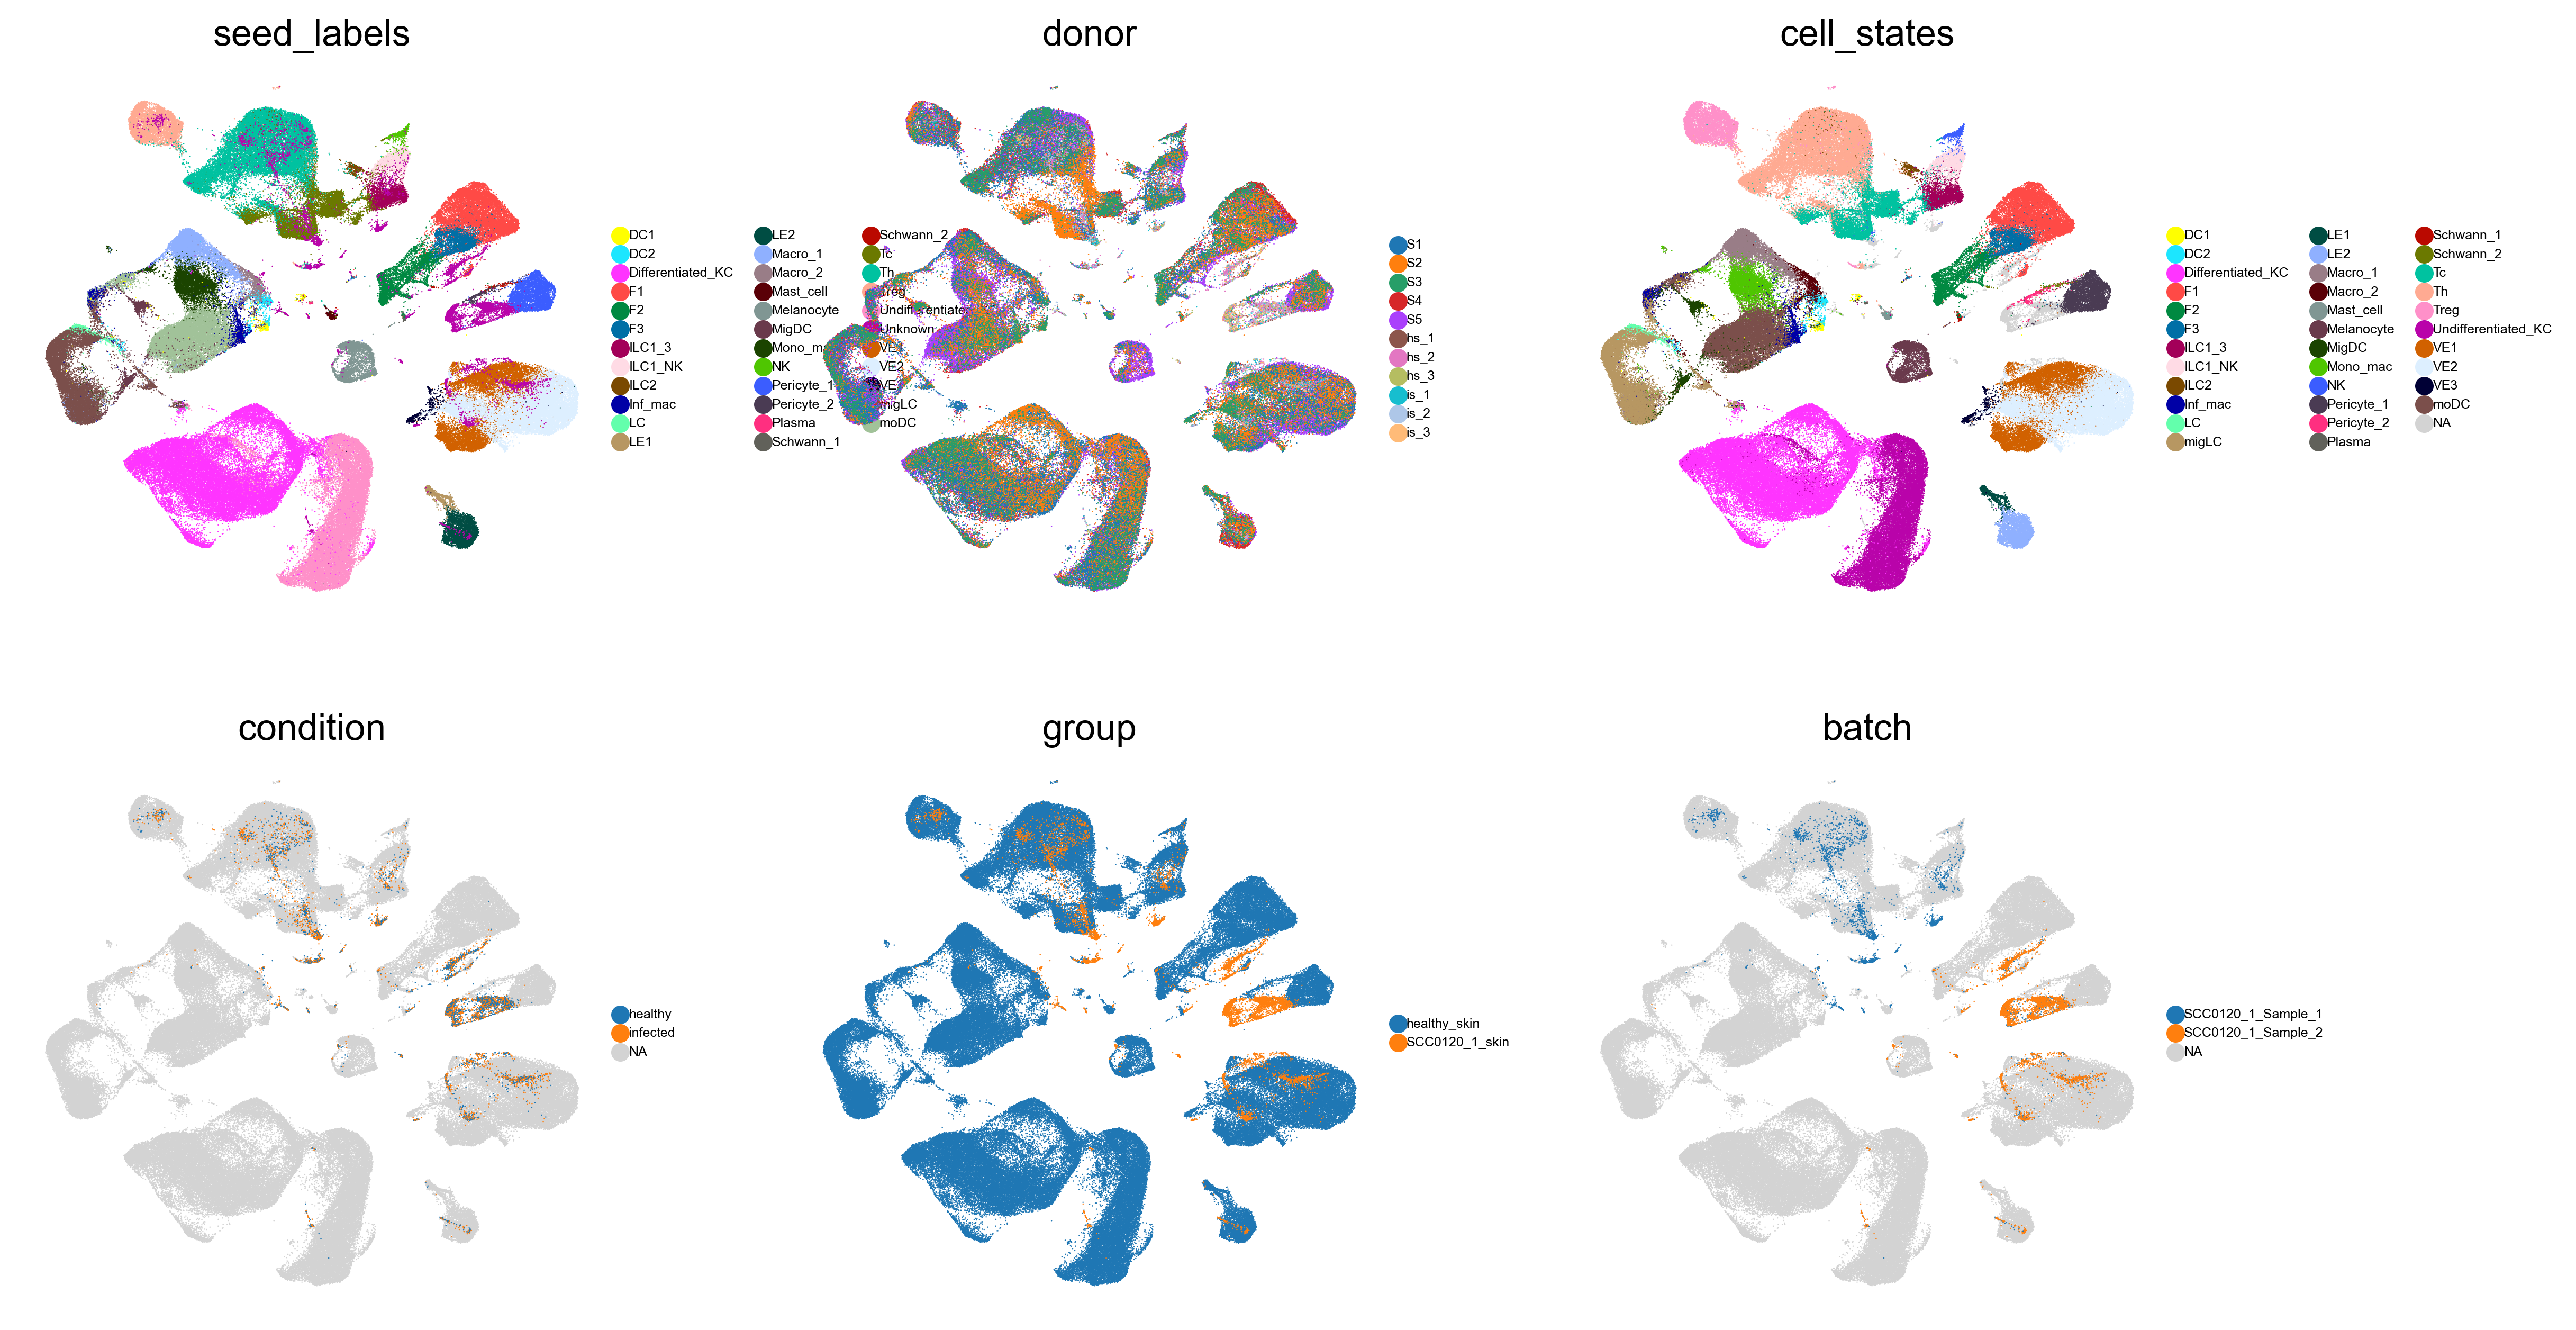

In [20]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 4, random_state = 1712)
sc.pl.umap(adata, frameon = False, color = ['seed_labels', 'donor', 'cell_states', 'condition', 'group', 'batch',], size = 1, legend_fontsize = 5, ncols = 3)

### Export annotated object

In [22]:
SCC0120_1_skin_annotated = adata[adata.obs['group'].isin(['SCC0120_1_skin'])]
SCC0120_1_skin_annotated

View of AnnData object with n_obs × n_vars = 7479 × 7000
    obs: 'sample_id', 'Status', 'Site', 'Tissue', 'Location', 'donor_id', 'Sex', 'full_clustering', 'seed_labels', 'donor', 'cell_states', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_CITE', 'nFeature_CITE', 'nCount_PROT', 'nFeature_PROT', 'percent.mt', 'sample', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'tissue', 'condition', 'n_genes', 'doublet_scores', 'predicted_doublets', 'hashtag', 'unique', 'group', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-SCC0120_1_skin', 'feature_types-SCC0120_1_skin', 'mt-SCC0120_1_skin', 'ribo-SCC0120_1_skin', 'n_cells_by_counts-SCC0120_1_skin', 'mean_counts-SCC0120_1_skin', 'pct_dropout_by_counts-S

In [25]:
del(SCC0120_1_skin_annotated.obs['predicted_doublets'])

In [26]:
SCC0120_1_skin_annotated.write('../data/SCC0120_1_Skin_scANVI_annot_ctl230702.h5ad')